# Wine Analysis

## Aron Sun and Jordan Foster

## CMSC320

## Introduction

Today, the mention of a wine is almost synonomus to its quality. In this regard, the question we wanted answered was is there some wines that are inheriently better than other wines? One way to judge the quality of wine is by setiment. Often setiment is generated by the consumer in the form of reivews on the internet. However, wine setiment is not only exclusive to the consumer but also to a small group of professional wine tasters. These professional are often critizced for rating wines randomly with no ryme or reason. So we wanted to answer the age old quesiton, do professional wine tasters really know what they are doing?

# Data Collection

There are alot of professional wine tasters, and thier reivews of wines can be found on many websites. However, we also found a precomplied dataset of professional wine reviews on kaggle.com that we decieded to use.

In [1]:
!pip install spacy
!pip install nltk
import spacy
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.corpus import twitter_samples
import pandas as pd
import numpy as np
import seaborn as sns
import string
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# raw data
wine_df = pd.read_csv("wine.csv")
reviews = wine_df
reviews = reviews.drop(['Unnamed: 0', 'description', 'designation', 'region_2', \
                        'taster_twitter_handle', 'title'], axis=1)
# reviews = wine_df.sample(20000).reset_index()
wine_df = wine_df.drop(['Unnamed: 0', 'description', 'designation', 'region_2', \
                        'taster_twitter_handle', 'title'], axis=1)
wine_df.head()

,country,points,price,province,region_1,taster_name,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,White Blend,Nicosia
1,Portugal,87,15.0,Douro,NaN,Roger Voss,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian
4,US,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks


# Data Cleanup

Numerical values are given to the columns with non-numerical values ('country', 'variety', 'province', 'region_1', 'variety', 'winery') in order for them to be used in the prediction of a wines score (points).

In [3]:
# assign numerical values to string columns
str_cols = ['country', 'variety', 'province', 'region_1', 'variety', 'winery', 'taster_name']

for col in str_cols:
    wine_df[col] = pd.factorize(wine_df[col])[0]

wine_df

,country,points,price,province,region_1,taster_name,variety,winery
0,0,87,NaN,0,0,0,0,0
1,1,87,15.0,1,-1,1,1,1
2,2,87,14.0,2,1,2,2,2
3,2,87,13.0,3,2,3,3,3
4,2,87,65.0,2,1,2,4,4
...,...,...,...,...,...,...,...,...
129966,5,90,28.0,8,-1,5,3,5244
129967,2,90,75.0,2,13,2,4,7639
129968,4,90,30.0,5,5,1,7,10215
129969,4,90,32.0,5,5,1,2,5348


## Data Exploration

Before we get into the data analysis let's get a general overivew of some wine trends and relationships that we should be aware of. We first want to get a good understanding of the spread of the data. Data visualization will help us highlight the relationship between trends in the dataset that we might have otherwise missed just by look at the dataframe.

### Summary of Data

First and foremost, lets get a summary of the rows and columns we will be dealing with. This includes what the data type, number of missing values, unique values the value, and the type of value we are dealing with. This allows us to get a good summary of each column in the wine dataframe.

From the summary table, we can see many of these variables are categorical. In addtion, we can see that region 1, price, and taster name have a lot of missing values. One interesting finding from this summary table we would otherwise have not known is that there are only 19 unique wine tasters in this data. This means that 19 names tasted around 130,000 wines, which is pretty impressive!

In [55]:
def summary_table(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    return summary

In [5]:
summary_table(reviews)

Dataset Shape: (129971, 8)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,country,object,63,43,Italy,Portugal,US,2.77
1,points,int64,0,21,87,87,87,3.64
2,price,float64,8996,390,NaN,15,14,5.77
3,province,object,63,425,Sicily & Sardinia,Douro,Oregon,5.05
4,region_1,object,21247,1229,Etna,NaN,Willamette Valley,7.89
5,taster_name,object,26244,19,Kerin O’Keefe,Roger Voss,Paul Gregutt,3.39
6,variety,object,1,707,White Blend,Portuguese Red,Pinot Gris,5.67
7,winery,object,0,16757,Nicosia,Quinta dos Avidagos,Rainstorm,12.98


### Distribution of Points and Price

As we mentioned before, most of the columns are categorical varibles. However, there are 2 quantitative columns, which are points and price. Here we just perform a simple description of basic stats on these two columns. From this, one intersting thing that we can see is the points only range from 80 to 100, which is a pretty small range given the number of rows in the dataset.

In [6]:
reviews.describe()

Statistics of numerical data: 


,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


### Graph of Point Distribution

The histogram below further shows how the points ranging from 80 to 100, which was mentioned above, is ditributed. As you can see, the point distribution is almost normal. This is pretty insightful because it suggests that these wine tasters cluster thier reviews towards the middle, rarely giving really low or high points. Next to the histogram, is a cummlative distribution of points, which reinforces the idea that most points are clusted in the middle.

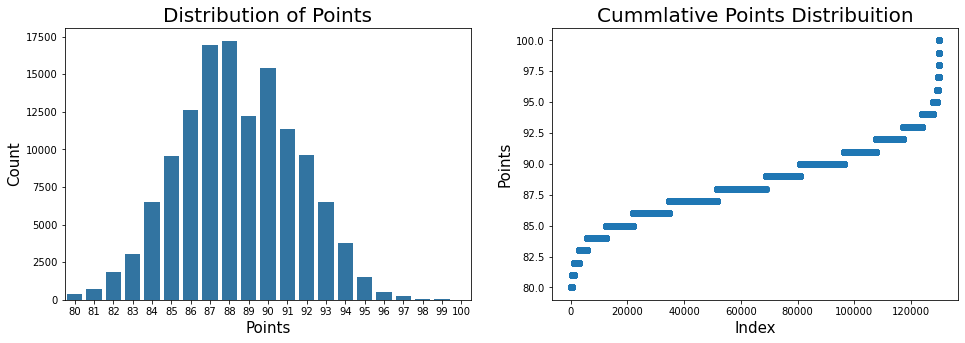

In [38]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
g = sns.countplot(x='points', data=reviews, color='#1f77b4')
g.set_title("Distribution of Points", fontsize=20) 
g.set_xlabel("Points", fontsize=15) 
g.set_ylabel("Count", fontsize=15) 

plt.subplot(1,2,2)  
plt.scatter(range(reviews.shape[0]), np.sort(reviews.points.values), color='#1f77b4')
plt.xlabel('Index', fontsize=15)  
plt.ylabel('Points', fontsize=15)  
plt.title("Cummlative Points Distribuition", fontsize=20) 

plt.show()

### Rating Categories

This is much like the previous graph, but here we first convert all the points into a categorical varible with a range from 0 to 5 before we plot. By converting the points into a categorical variable, we will later be able to perform some machine learning algorithms on the data. As you can see from the plot, there are barely any points in the 0th and 5th categories.

In [8]:
def points_to_categorical(points):
    if points in list(range(80,83)):
        return 0
    elif points in list(range(83,87)):
        return 1
    elif points in list(range(87,90)):
        return 2
    elif points in list(range(90,94)):
        return 3
    elif points in list(range(94,98)):
        return 4
    else:
        return 5

reviews["rating_cat"] = reviews["points"].apply(points_to_categorical)

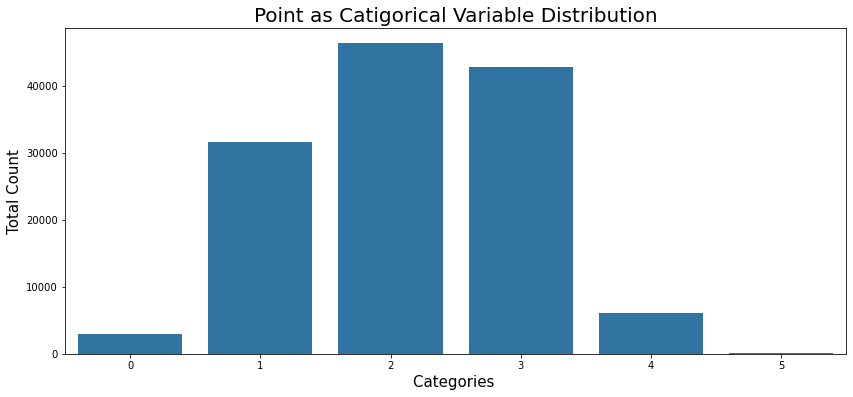

In [39]:
total = len(reviews)
plt.figure(figsize=(14,6))

g = sns.countplot(x='rating_cat',  color='#1f77b4',
                  data=reviews)
g.set_title("Point as Catigorical Variable Distribution", fontsize=20)
g.set_xlabel("Categories ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)

sizes=[]

plt.show()

### Price Distribution

Below we can see the price distribution for all prices less than 300. As you can see, there are relativly few wines above 100. Most wines are clusted between 0 and 100 with a the peak wine price at around 20 dollars. It is intersting how fast the frequency of wines drop off, signaling a very saturated wine market for wines less than 100 dollars.

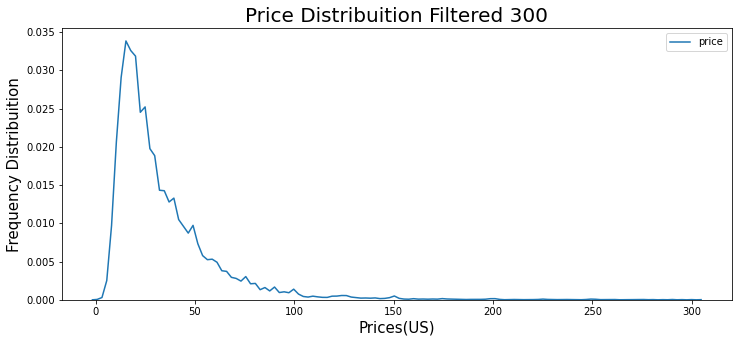

In [53]:
plt.figure(figsize=(12,5))

g = sns.kdeplot(reviews.query('price < 300').price, color='#1f77b4')
g.set_title("Price Distribuition Filtered 300", fontsize=20)
g.set_xlabel("Prices(US)", fontsize=15)
g.set_ylabel("Frequency Distribuition", fontsize=15)


plt.show()

### Scatter Plot of Points vs Price of Wine

So far, we have only been looking at one variable. Argubly one of the most important relationships in this dataset is that of points and price. In essence, we want to start to ask the question of how does price affect the points given by the wine reviewers. For the plots below, we should expect a linear trend where the cheaper the price, the lesser the points awareded, and higher prices being rewareded more points. In addition, we should see high value wines to be closer in the low price and high points quandrant, and we should expect low value wines to be in the high price and low points category. Looking at the scatter and hexplot below for wines with price less than 300, we can that almost all wines follow this trend, but there is a clear but slight skew torwards low price and high points wines. The hexplot shows us that most wines are priced at around 25 dollars and given 87.5 points.

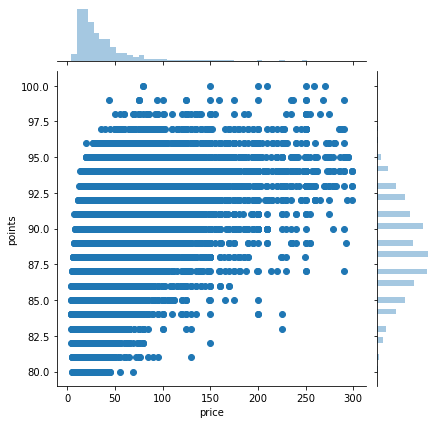

In [65]:
#Scatter Plot
sns.jointplot(x='price', y='points', data=reviews[reviews['price'] < 300])

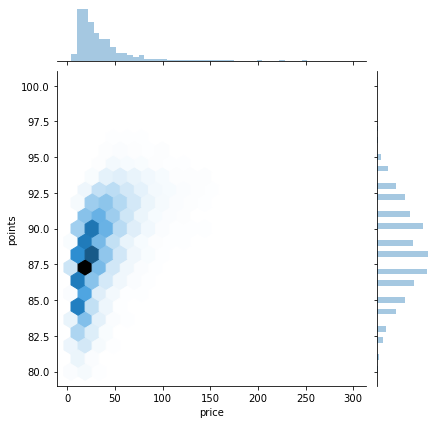

In [66]:
# hexplot
sns.jointplot(x='price', y='points', data=reviews[reviews['price'] < 300], kind='hex', gridsize=20)

## Data Analysis

Shows simple prediction methods cant acurately predict the score of a wine based off of the parameters used above.

## Note:

idk which one we want to include

In [21]:
X = wine_df.drop(['points'], axis=1).to_numpy('int64')
y = wine_df['points']
X

array([[                   0, -9223372036854775808,                    0,
        ...,                    0,                    0,
                           0],
       [                   1,                   15,                    1,
        ...,                    1,                    1,
                           1],
       [                   2,                   14,                    2,
        ...,                    2,                    2,
                           2],
       ...,
       [                   4,                   30,                    5,
        ...,                    1,                    7,
                       10215],
       [                   4,                   32,                    5,
        ...,                    1,                    2,
                        5348],
       [                   4,                   21,                    5,
        ...,                    1,                    7,
                        2777]])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### linear regression

In [23]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([-4.65322364e-09, -5.12190003e-20, -8.97987981e-08, -5.55497062e-07,
        2.36155973e-10, -1.03702590e-07, -8.99944558e-05])

In [24]:
model.score(X_test,y_test)

0.015686482196156426

### linear discriminant analysis

In [25]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [26]:
lda_model.score(X_test,y_test)

0.13904533284091958

### classification tree

In [27]:
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
dt_model.score(X_test,y_test)

0.2434678238389807

### kNN

In [29]:
n = int(np.floor(np.sqrt(len(wine_df))))
neigh = KNeighborsClassifier(n_neighbors=n)
neigh.fit(X_test, y_test)

KNeighborsClassifier(n_neighbors=360)

In [30]:
neigh.score(X_test,y_test)

0.1538177453605392

### Random Forrest

In [31]:
# takes a LONG time to run

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
rf_model.score(X_test,y_test)

0.2583941156556797

**Note:** In all of these analysis the the text description of the review isnt used. If its included can we do better?

# NLP

we want to use NLP to categorize what a good review/description for wine looks like, heres the descriptions

In [33]:
reviews['description'].head()

KeyError: 'description'

Stop words are words such as prepositions and possesive words that we will remove for NLP

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words

Tokenizer that removes stop words and also adds a frequency count to `freq_dict`

In [ ]:
def tokenize(s):
    # remove punc
    s = s.translate(str.maketrans('', '', string.punctuation))
    toks = nltk.word_tokenize(s)
    filtered_toks = [w for w in toks if not w in stop_words]
    return filtered_toks

In [ ]:
tok_descrip = reviews['description'].apply(tokenize)
reviews['tok_descrip'] = tok_descrip
reviews['tok_descrip']

In [ ]:
reviews_words = np.concatenate(reviews.tok_descrip)
reviews_words

In [ ]:
review_fd = nltk.FreqDist(reviews_words)
review_fd

Now we want to remove unnecessary words such as wine, the, this, drink, etc...

In [ ]:
words_to_pop = ['Wine', 'The', 'This', 'Its', 'A', 'Is', 'It', 'Drink']
for key in words_to_pop:
    if key in review_fd.keys():
        review_fd.pop(key)
    if key.lower() in review_fd.keys():
        review_fd.pop(key.lower())
        
review_fd

These are the top 20 most common words used in the review for wine

In [ ]:
# Data to plot
labels = []
sizes = []

for x, y in review_fd.most_common(20):
    labels.append(x)
    sizes.append(y)

dims = (20,10)
fig, ax = plt.subplots(figsize=dims)
ax.set(xlabel='word', ylabel='frequency')
sns.barplot(x=labels[:20], y=sizes[:20]).set_title('Top 20 Most Common Words')

Now that we have the descriptions tokenized and all unnecessary words removed we con continue to perform sentiment analysis on the reviews